In [1]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns

# Завдання 1
У цьому завданні вам потрібно завантажити ось цей датасет. Ми з вами вже працювали з ним коли вивчали pandas. Це все також Топ-50 книг, що найбільше продаються на Amazon в період з 2009 по 2019 роки. Потрібно виконати наступне:

## 1.1. Створити спарк сесію.

In [2]:
from pyspark.sql import SparkSession

spark_session = SparkSession.builder.getOrCreate()

## 2.2. Прочитати датасет в датафрейм.

In [3]:
df = spark_session.read.csv("bestsellers with categories.csv", header=True, inferSchema=True)
df.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

## 2.3. Використовуючи тільки RDD, обчислити середню ціну всіх книг, у яких рейтинг вищий за 4.7

In [4]:
df.filter(df["User Rating"] > 4.7).agg({"Price":"avg"}).show()

+-----------------+
|       avg(Price)|
+-----------------+
|10.69832402234637|
+-----------------+



## 2.4. Побудувати гістограму розподілу рецензій (стовпчик Reviews).

Text(0.5, 0, 'Number of review')

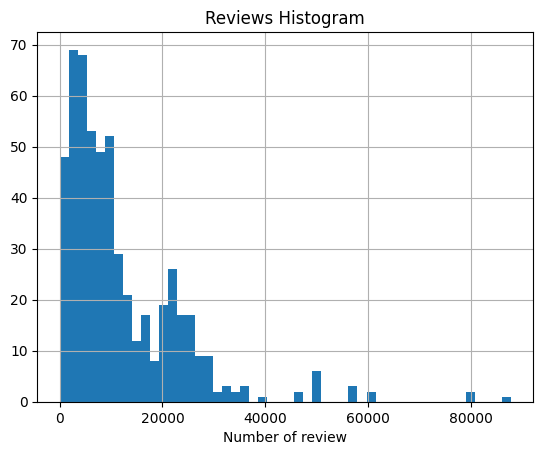

In [5]:
df.toPandas()["Reviews"].hist(bins=50)
plt.title("Reviews Histogram")
plt.xlabel("Number of review")

## 2.5. Побудувати матрицю кореляції для стовпців "User Rating", "Reviews" та "Price".

In [6]:
corr_matrix = df.select(["User Rating", "Reviews", "Price"]).toPandas().corr()
print(corr_matrix)

             User Rating   Reviews     Price
User Rating     1.000000 -0.001729 -0.133086
Reviews        -0.001729  1.000000 -0.109182
Price          -0.133086 -0.109182  1.000000


It seems that "User Rating", "Reviews", and "Price" are not correlated

## 2.6. Використовуючи бібліотеку seaborn, побудувати парні графіки (pairplots) стовпців "User Rating", "Reviews" та "Price".

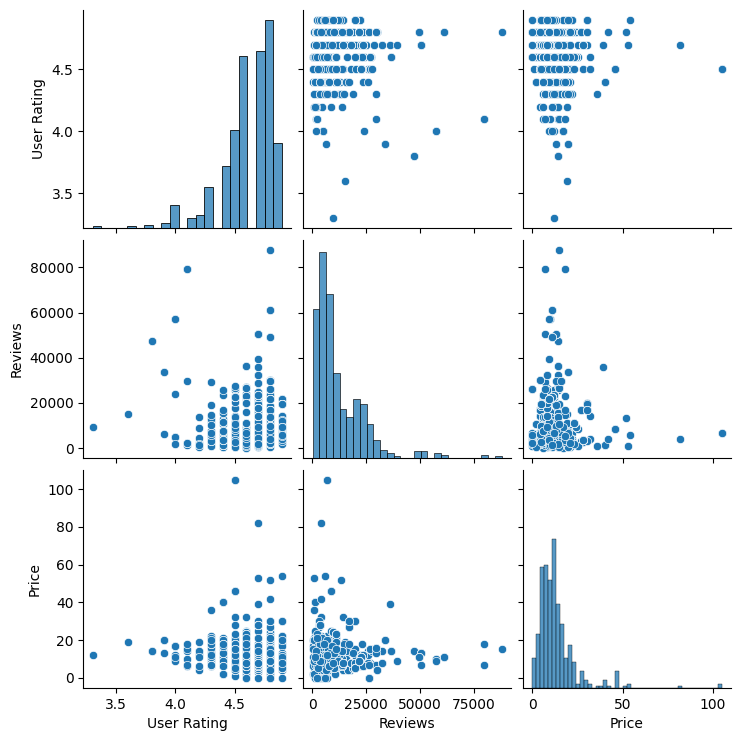

In [7]:
sns.pairplot(df.toPandas()[["User Rating","Reviews", "Price"]])

# Завдання 2
Під час виконання цього завдання дозволяється використовувати лише Spark SQL. Для датасету з попереднього завдання виконайте наступне:

## 2.1. Знайдіть автора з найвищим рейтингом.

In [8]:
df.createOrReplaceTempView("books")

spark_session.sql("""
                    SELECT Author, avg(`User Rating`) as `Average rating`
                    FROM books
                    GROUP by Author
                    ORDER BY `Average rating` desc
                    LIMIT 1
                  """
).collect()

[Row(Author='Jill Twiss', Average rating=4.9)]

## 2.2. Знайдіть трьох авторів із найнижчим рейтингом.

In [9]:
spark_session.sql("""
                    SELECT Author, avg(`User Rating`) as `Average rating`
                    FROM books
                    GROUP by Author
                    ORDER BY `Average rating` 
                    LIMIT 3
                  """
).collect()

[Row(Author='Donna Tartt', Average rating=3.9),
 Row(Author='Gillian Flynn', Average rating=4.0),
 Row(Author='Muriel Barbery', Average rating=4.0)]

## 2.3. Визначте, який автор отримав найбільшу кількість рецензій.

In [10]:
spark_session.sql("""
                    SELECT Author, sum(`Reviews`) as `Total reviews`
                    FROM books
                    GROUP by Author
                    ORDER BY `Total reviews` desc
                    LIMIT 1
                  """
).collect()

[Row(Author='Suzanne Collins', Total reviews=278329)]

## 2.4. Визначте, який автор написав найбільшу кількість книг за весь доступний у даних період.

In [11]:
spark_session.sql("""
                    SELECT Author, COUNT(*) as `Total books`
                    FROM books
                    GROUP by Author
                    ORDER BY `Total books` desc
                    LIMIT 1
                  """
).collect()

[Row(Author='Jeff Kinney', Total books=12)]

## 2.5. Визначте, яка книга жанру "Fiction" має найменший рейтинг.

In [12]:
spark_session.sql("""
                    SELECT Name, Genre, `User Rating`
                    FROM books
                    WHERE Genre = 'Fiction'
                    ORDER BY `User Rating`
                    LIMIT 1
                  """
).collect()

[Row(Name='The Casual Vacancy', Genre='Fiction', User Rating=3.3)]

## 2.6. Визначте, яка книга жанру "Non Fiction" має найвищий рейтинг.

In [13]:
spark_session.sql("""
                    SELECT Name, Genre, `User Rating`
                    FROM books
                    WHERE Genre = 'Non Fiction'
                    ORDER BY `User Rating` desc
                    LIMIT 1
                  """
).collect()

[Row(Name='Hamilton: The Revolution', Genre='Non Fiction', User Rating=4.9)]

# Завдання 3

## 3.1. Побудуйте гістограму середньої кількості рецензій за роками. 

<Axes: xlabel='Year'>

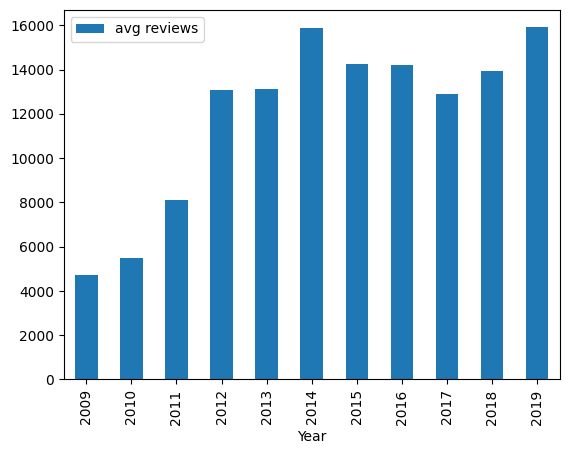

In [50]:
spark_session.sql("""
                    SELECT Year, avg(`Reviews`) as `avg reviews`
                    FROM books
                    GROUP by Year
                    ORDER BY Year
                  """
).toPandas().plot(x='Year', y='avg reviews', kind='bar')

## 3.2. У вигляді окремої гістограми візуалізуйте кількість книг жанру "Fiction" та "Non Fiction" за весь доступний період.

<Axes: xlabel='Year'>

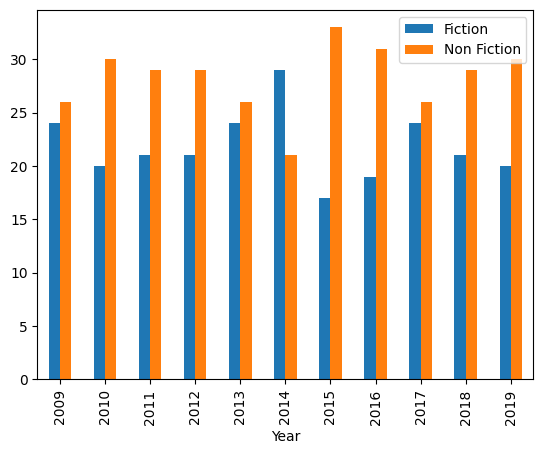

In [115]:
spark_session.sql("""
                    SELECT Year,
                        COUNT(CASE WHEN Genre = 'Fiction' THEN 1 ELSE NULL END) as `Fiction`,
                        COUNT(CASE WHEN Genre = 'Non Fiction' THEN 1 ELSE NULL END) as `Non Fiction`
                    FROM books
                    GROUP by Year
                    ORDER by Year;
                """
).toPandas().plot(x='Year', y=['Fiction','Non Fiction'], kind='bar')
